/tmp/ipykernel_5799/1112030456.py:12: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


<Figure size 3000x3000 with 0 Axes>

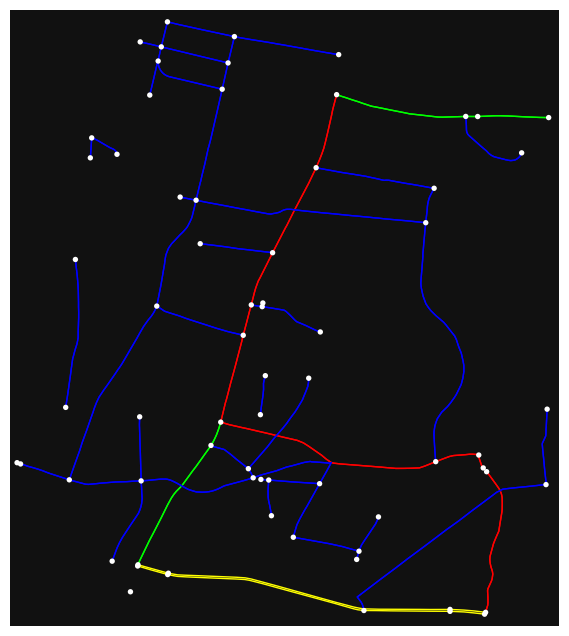

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [42]:

import osmnx as ox
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 自宅周辺の軽いデータ
latitude_start = 35.336452
longitude_start = 136.922696
latitude_end = 35.297945
longitude_end = 136.971245
# キャッシュを使う
ox.config(use_cache=True, log_console=True)

graph = ox.graph_from_bbox(north=max(latitude_start, latitude_end),
                           south=min(latitude_start, latitude_end),
                           east=max(longitude_start, longitude_end),
                           west=min(longitude_start, longitude_end),
                           network_type='drive',
                           
                           custom_filter='["highway"~"secondary|secondary_link|primary|primary_link|trunk|trunk_link"]["lanes"=2]')
graph2 = ox.graph_from_bbox(north=max(latitude_start, latitude_end),
                           south=min(latitude_start, latitude_end),
                           east=max(longitude_start, longitude_end),
                           west=min(longitude_start, longitude_end),
                           network_type='drive',
                           simplify=True,
                           retain_all=True,
                           custom_filter='["highway"="tertiary"]')
graph = nx.compose(graph, graph2)

gdf_edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)

gdf_edges["is_target"] = np.where(
    (gdf_edges["length"] >= 800),
    1,
    0,
)
gdf_edges = gdf_edges[gdf_edges["is_target"] == 1]

# 逆方向の道を削除する
drop_target = []
for index, row in gdf_edges.iterrows():
    # drop_indexにindex[1], index[0]が存在する場合はなにもしない
    if (index[1], index[0], 0) in drop_target:
        continue
    if (index[0], index[1], 0) in drop_target:
        continue
    drop_target.append(index)
gdf_edges = gdf_edges[gdf_edges.index.isin(drop_target)]

def calculate_angle_between_vectors(A, B, C):
    vector_AB = np.array(B) - np.array(A)
    vector_BC = np.array(C) - np.array(B)
    
    dot_product = np.dot(vector_AB, vector_BC)
    norm_AB = np.linalg.norm(vector_AB)
    norm_BC = np.linalg.norm(vector_BC)
    
    cosine_theta = dot_product / (norm_AB * norm_BC)
    angle_rad = np.arccos(cosine_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# 座標間の角度の変化の合計値を求める
gdf_edges['geometory_angle_total'] = gdf_edges['geometry'].apply(
    lambda x: sum([calculate_angle_between_vectors(x.coords[i-1], x.coords[i], x.coords[i+1]) for i in range(1, len(x.coords)-1)])
)

# 合計角度と距離の比率を求める
gdf_edges['geometory_angle_rate'] = gdf_edges['geometory_angle_total'] / gdf_edges['length']

# エッジ内のノード数を求める
graph_all = ox.graph_from_bbox(north=max(latitude_start, latitude_end),
                           south=min(latitude_start, latitude_end),
                           east=max(longitude_start, longitude_end),
                           west=min(longitude_start, longitude_end),
                           network_type='drive',
                           simplify=True,
                           retain_all=True)
all_nodes = ox.graph_to_gdfs(graph_all, nodes=True, edges=False)
gdf_edges['node_cnt'] = 0
for index, row in gdf_edges.iterrows():
  # ジオメトリーの座標と一致するノードを取得する
  nodes = all_nodes[all_nodes.geometry.intersects(row.geometry)]
  # 進行方向と逆方向のノードを除外して分岐数を計算する
  gdf_edges.at[index, 'node_cnt'] = nodes['street_count'].sum() - (len(nodes) * 2)

# 評価する
gdf_edges['score'] = (1 - gdf_edges['geometory_angle_rate']) * (1 - (gdf_edges['node_cnt'] / gdf_edges['length']))
gdf_edges['score_normalized'] = gdf_edges['score'] / gdf_edges['score'].max()
# score_normalizedを並び替え
gdf_edges = gdf_edges.sort_values('score_normalized', ascending=False)

# score_normalizedの上位5件を表示する
target_edges = gdf_edges.head(5)
graph = ox.graph_from_gdfs(gdf_nodes, target_edges)

edge_color = []
for u, v, k, data in graph.edges(keys=True, data=True):
    if 'highway' in data:
        if data['highway'] == 'primary' or data['highway'] == 'primary_link':
            edge_color.append('#FF0000')  # 赤色: primary
        elif data['highway'] == 'secondary' or data['highway'] == 'secondary_link':
            edge_color.append('#00FF00')  # 緑色: secondary
        elif data['highway'] == 'trunk' or data['highway'] == 'trunk_link':  
            edge_color.append('#FFFF00')  # 黄色: trunk
        elif data['highway'] == 'tertiary':  
            edge_color.append('#0000FF')  # 青色: tertiary
        else:
            print(data)
            edge_color.append('#00FFFF') # 水色: ? 複合
    else:
        edge_color.append('#FFFFFF')  # 白色

plt.figure(figsize=(30, 30))  # 画像サイズを調整
ox.plot_graph(graph, edge_color=edge_color)  # fig_heightとfig_widthでサイズを指定

# # 地図を表示する
# map = ox.plot_graph_folium(graph, edge_width=2)
# map